In [1]:
import os
import cv2   # For computer vision
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout
from keras.utils.np_utils import to_categorical
from keras.models import load_model
from PIL import Image

In [2]:
path1=r"E:\Mask_NoMask" #path of the main folder
cate=['with_mask','without_mask']

In [3]:
image_size = 200
input_image=[]
for i in cate:
    # valeu of i would be dog and then cat
    folders = os.path.join(path1 ,i)
    label = cate.index(i) # we need to tell software which image is of cat and which is of dog
    for image in os.listdir(folders):
        
        image_path = os.path.join(folders , image)
        image_array = cv2.imread(image_path) # using the cv2 i am reading the image and storing in variable image_array
        image_array =cv2.resize(image_array , (image_size , image_size) ) # resizing each image to 200 * 200
        input_image.append([image_array , label])

In [4]:
np.random.shuffle(input_image)
X=[]
Y=[]

In [5]:
for X_values , labels in input_image:
    
    X.append(X_values)
    Y.append(labels)

In [6]:
np.unique(Y)

array([0, 1])

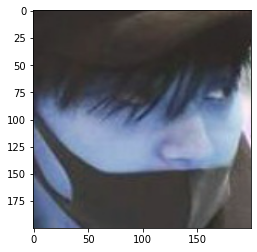

In [7]:
plt.imshow(X[14])

In [8]:
X=np.array(X)
Y=np.array(Y)

In [9]:
X=X/255

In [10]:
model=Sequential()
model.add(Conv2D(filters=100,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=100,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=100,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=100,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())


model.add(Dense(50,activation='relu',input_shape=X.shape[1:]))
model.add(Dropout(0.2)) #10%of the neurons would be removed
model.add(Dense(2,activation='softmax'))

In [11]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [12]:
model.fit(X,Y,epochs=5, validation_split=.15, batch_size=32)

Epoch 1/5
201/201 [==============================] - 1004s 4s/step - loss: 0.4655 - accuracy: 0.7592 - val_loss: 0.2490 - val_accuracy: 0.8976
Epoch 2/5
201/201 [==============================] - 881s 4s/step - loss: 0.2202 - accuracy: 0.9194 - val_loss: 0.2510 - val_accuracy: 0.9170
Epoch 3/5
201/201 [==============================] - 743s 4s/step - loss: 0.1808 - accuracy: 0.9394 - val_loss: 0.1747 - val_accuracy: 0.9320
Epoch 4/5
201/201 [==============================] - 717s 4s/step - loss: 0.1331 - accuracy: 0.9535 - val_loss: 0.1674 - val_accuracy: 0.9444
Epoch 5/5
201/201 [==============================] - 952s 5s/step - loss: 0.1161 - accuracy: 0.9607 - val_loss: 0.1645 - val_accuracy: 0.9532


In [18]:
model.save("my_mask_NoMask_model.h5")#(to save model use .h5 extension)

In [23]:
import cv2
import numpy as np
from keras.models import load_model

model=load_model("my_mask_NoMask_model.h5")

results={0:'Mask found',1:'Mask not found'}
GR_dict={0:(0,255,255),1:(0,255,0)}

rect_size = 4
cap = cv2.VideoCapture(0)


haarcascade = cv2.CascadeClassifier(r"E:/Harcascade/haarcascade_frontalface_alt.xml")
while True:
    (rval, im) = cap.read()
    im=cv2.flip(im,1,1)


    rerect_size = cv2.resize(im, (im.shape[1] // rect_size, im.shape[0] // rect_size))
    faces = haarcascade.detectMultiScale(rerect_size)
    for f in faces:
        (x, y, w, h) = [v * rect_size for v in f]

        face_img = im[y:y+h, x:x+w]
        rerect_sized=cv2.resize(face_img,(200,200))
        normalized=rerect_sized/255.0
        reshaped=np.reshape(normalized,(1,200,200,3))
        reshaped = np.vstack([reshaped])
        result=model.predict(reshaped)


        label=np.argmax(result,axis=1)[0]

        cv2.rectangle(im,(x,y),(x+w,y+h),GR_dict[label],2)
        cv2.rectangle(im,(x,y-40),(x+w,y),GR_dict[label],-1)
        cv2.putText(im, results[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,0,0),2)

    cv2.imshow('Liv Camera', im)
    key = cv2.waitKey(10)

    if key == 27: # use the escape key
        break

cap.release()

cv2.destroyAllWindows()